In [ ]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics import Breakup
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

## AlwaysN fragments, Golovin kernel

In [ ]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
#from pystrict import strict

#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**10
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 100, 200]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.0)
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [ ]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
#coalescence = Coalescence(settings.kernel, settings.coal_eff adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

### <i> GPU testing

In [ ]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
#from pystrict import strict

#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 4
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(0.0)
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [ ]:
settings = Settings()
backend = GPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
#coalescence = Coalescence(settings.kernel, settings.coal_eff adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

* Sometimes hangs on illegal print statements in Numba
* current source of error: self.kernel is computed wrong

## SLAMS fragmentation kernel

In [ ]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import Golovin
from PySDM.physics.breakup_fragmentations import SLAMS
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict
from PySDM.products.dynamics.breakup import BreakupFragments

@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**10
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1.5e3 / si.second)
        self.breakup_kernel = Golovin(b = 1e8 / si.second)
        self.fragmentation = SLAMS()
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [ ]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.breakup_kernel, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.breakup_kernel, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), BreakupFragments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")

## Coalescence Efficiencies

In [ ]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import Golovin, Hydrodynamic
from PySDM.physics.breakup_fragmentations import SLAMS, AlwaysN
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict
from PySDM.products.dynamics.breakup import BreakupFragments

@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**10
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1e5 / si.second)
        #self.kernel = Hydrodynamic()
        self.coal_eff = ConstEc(0.9)
        #self.coal_eff = Berry1967()
        #self.breakup_kernel = Golovin(b = 1.5e4 / si.second)
        #self.fragmentation = SLAMS()
        self.fragmentation = AlwaysN(n=5)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

In [ ]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
#coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")

## GPU test

In [1]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics import Breakup
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius, KMoments
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

In [2]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
#from pystrict import strict

#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**8
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 123
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1500e3 / si.second)
        self.coal_eff = ConstEc(0.5)
        self.fragmentation = SLAMS()
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

0
[27.26101585] [99.997952] [9.99979520e+07 1.19039420e-05 2.81166553e-18]
1


/home/edejong/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


8
[18.2854189] [399.991808] [3.99991808e+08 1.19039420e-05 5.01218254e-19]
2
2
[18.71598443] [399.991808] [3.99991808e+08 1.19039420e-05 4.36455065e-19]


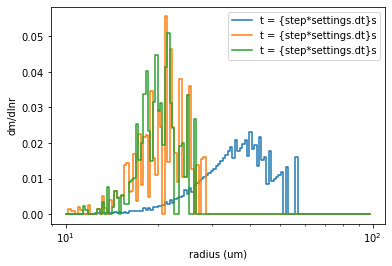

In [3]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
#coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), KMoments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get(), core.products['M0-Mk'].get(3))
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

0
[27.26100076] [99.997952] [9.99979520e+07 1.19039437e-05 2.81166609e-18]
1
5
[21.21566312] [249.99488] [2.49994880e+08 1.19039471e-05 8.76977543e-19]
2
7
[14.39075712] [874.981925] [8.74981925e+08 1.19039349e-05 2.04032746e-19]


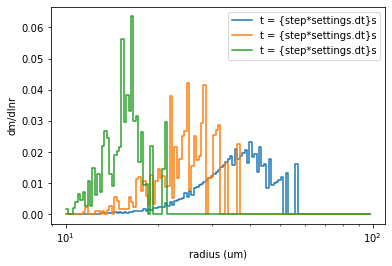

In [4]:
settings = Settings()
backend = GPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
#coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), KMoments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get(), core.products['M0-Mk'].get(3))
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

## Different random number for each fragmentation pair call

In [1]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics import Breakup
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius, KMoments
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

In [2]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
#from pystrict import strict

#@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 4
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 123
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1500e3 / si.second)
        self.coal_eff = ConstEc(0.5)
        #self.fragmentation = AlwaysN(n=3)
        self.fragmentation = SLAMS()
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

0
[27.16174765] [99.998] [9.99980000e+07 1.09186528e-05 1.96270050e-18]
1
[29.11339435] [99.998] [9.99980000e+07 1.09186528e-05 1.37509402e-18]
2
[16.2238514] [574.9885] [5.74988500e+08 1.09186528e-05 2.62508076e-19]


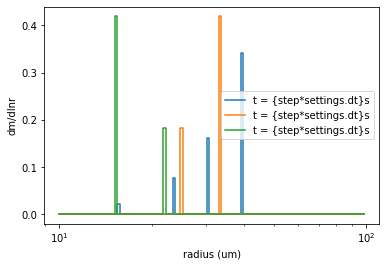

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
#coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
#builder.add_dynamic(coalescence)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), KMoments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get(), core.products['M0-Mk'].get(3))
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()